In [2]:
#Imports and setup
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor
from allensdk.api.queries.cell_types_api import CellTypesApi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

#Set up data directory
os.makedirs('cell_types', exist_ok=True)
manifest_path = './cell_types/manifest.json'
ctc = CellTypesCache(manifest_file=manifest_path)


In [3]:
#Human cells metadata
specimens = ctc.get_cells(species=[CellTypesApi.HUMAN])
print(f"Total human cells available: {len(specimens)}")

Total human cells available: 413


In [57]:
all_rows = []

for cell in tqdm(specimens):
    try:
        specimen_id = cell['id']
        data_set = ctc.get_ephys_data(specimen_id)
        sweeps = ctc.get_ephys_sweeps(specimen_id)

        for sweep in sweeps:
            if sweep.get('stimulus_units') != 'Amps':
                continue
            sweep_num = sweep['sweep_number']
            try:
                sweep_data = data_set.get_sweep(sweep_num)

                #Raw signal
                stim = sweep_data['stimulus'] * 1e12  # to pA
                voltage = sweep_data['response'] * 1e3  # to mV
                sampling_rate = sweep_data['sampling_rate']
                t = np.arange(len(stim)) / sampling_rate

                #Time window
                start_time = 1.0
                max_possible_end = len(t) / sampling_rate
                end_time = min(2.0, max_possible_end - 0.01)  # stay just under total time
                
                #Skip if sweep is too short
                if end_time - start_time <= 0.05:
                    raise ValueError("Sweep too short for spike feature extraction")

                #Spike Detection
                extractor = EphysSweepFeatureExtractor(t=t, v=voltage, i=stim, start=start_time, end=end_time)
                extractor.process_spikes()
                spike_times = extractor.spike_feature("threshold_t")
                spike_count = len(spike_times)

                #Basic Stimulus Features
                stim_duration = np.sum(np.abs(stim_win) > 10) / sampling_rate
                stim_integral = np.trapz(stim_win, dx=1.0/sampling_rate)
                stim_mean = np.mean(stim_win)
                stim_max = np.max(stim_win)
                stim_min = np.min(stim_win)
                stim_std = np.std(stim_win)

                peak_idx = np.argmax(np.abs(stim_win))
                stim_rise_time = (peak_idx / sampling_rate) if peak_idx > 0 else 0.0

                onset_idx = np.argmax(np.abs(stim_win) > 10)
                offset_idx = len(stim_win) - np.argmax(np.abs(stim_win[::-1]) > 10)
                stim_onset = t_win[onset_idx] if onset_idx > 0 else np.nan
                stim_offset = t_win[offset_idx] if offset_idx > 0 else np.nan
                stim_symmetry = (stim_offset - stim_onset) - stim_rise_time if (stim_offset and stim_onset) else np.nan

                #Voltage-Based Biological Features
                if spike_count > 0:
                    first_spike_latency = spike_times[0] - start_time
                else:
                    first_spike_latency = np.nan

                spike_diffs = np.diff(spike_times) if spike_count > 1 else []
                mean_isi = np.mean(spike_diffs) if len(spike_diffs) > 0 else np.nan
                std_isi = np.std(spike_diffs) if len(spike_diffs) > 0 else np.nan

                baseline_v = voltage[int(0.5 * sampling_rate):int(0.9 * sampling_rate)]
                baseline_vstd = np.std(baseline_v)

                row = {
                    "specimen_id": specimen_id,
                    "sweep_number": sweep_num,
                    "spike_count": spike_count,
                    "stim_mean": stim_mean,
                    "stim_max": stim_max,
                    "stim_min": stim_min,
                    "stim_std": stim_std,
                    "stim_duration": stim_duration,
                    "stim_integral": stim_integral,
                    "stim_rise_time": stim_rise_time,
                    "stim_onset": stim_onset,
                    "stim_offset": stim_offset,
                    "stim_symmetry": stim_symmetry,
                    "baseline_vstd": baseline_vstd
                }

                all_rows.append(row)

            except Exception as e:
                print(f"Sweep error {specimen_id}-{sweep_num}: {e}")
                continue

    except Exception as e:
        print(f"Cell error {cell['id']}: {e}")
        continue


100%|██████████| 413/413 [19:09<00:00,  2.78s/it]


In [61]:
df = pd.DataFrame(all_rows)
print(f"Total valid sweeps: {len(df)}")
df.head()


Total valid sweeps: 26483


,specimen_id,sweep_number,stim_mean,stim_max,stim_min,stim_std,stim_duration,stim_integral,stim_rise_time,spike_count,stim_onset,stim_offset,stim_symmetry,first_spike_latency,mean_isi,std_isi,baseline_vstd
0,525011903,7,0.30,100.0,0.0,5.469004,0.003,0.30,0.02,0,1.02,1.023,-0.017,NaN,NaN,NaN,0.089212
1,525011903,8,0.60,200.0,0.0,10.938007,0.003,0.60,0.02,0,1.02,1.023,-0.017,NaN,NaN,NaN,0.072852
2,525011903,9,0.90,300.0,0.0,16.407011,0.003,0.90,0.02,0,1.02,1.023,-0.017,NaN,NaN,NaN,0.144581
3,525011903,10,1.20,400.0,0.0,21.876015,0.003,1.20,0.02,0,1.02,1.023,-0.017,NaN,NaN,NaN,0.135913
4,525011903,12,1.35,450.0,0.0,24.610514,0.003,1.35,0.02,0,1.02,1.023,-0.017,NaN,NaN,NaN,0.087869


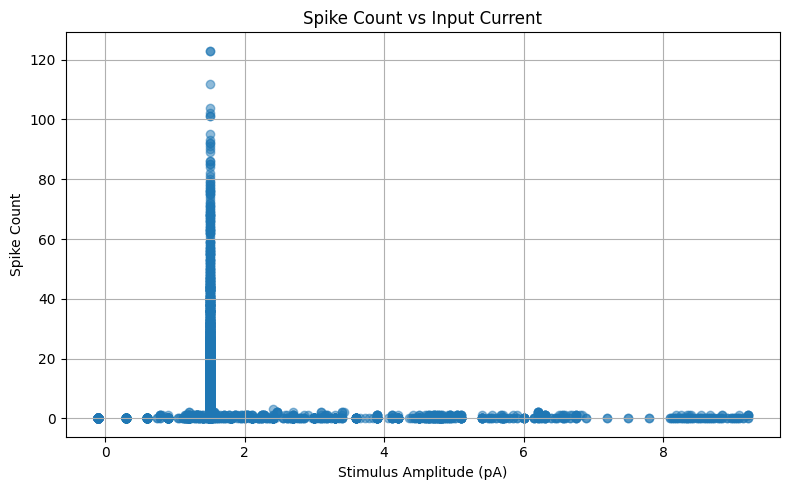

In [72]:
plt.figure(figsize=(8, 5))
plt.scatter(df['stim_mean'], df['spike_count'], alpha=0.5)
plt.xlabel("Stimulus Amplitude (pA)")
plt.ylabel("Spike Count")
plt.title("Spike Count vs Input Current")
plt.grid(True)
plt.tight_layout()
plt.savefig('../spike_count_vs_current.png', dpi=300)
plt.show()


In [65]:
#Save the cleaned dataset for model training
df.to_csv('../spikecount_dataset.csv', index=False)
print("Saved cleaned dataset to ../spikecount_dataset.csv")


Saved cleaned dataset to ../spikecount_dataset.csv
